In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

# input_dir = "/home/xin/Dropbox/BrainImaging_ML/multidimensional_age_prediction/out03_age_prediction"

input_dir = "out03_age_prediction_hc2_stdz_age_reverse_notract_fa_scale_thresh.09"
output_dir = "out04_fit_brain_age_hc2_stdz_age_reverse_notract_fa_scale_thresh.09"

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

model = 'km4'

method = 'ridge'
# method = 'svrlinear'


## healthy controls:
#scatter_data = pd.read_csv(input_dir+"/out03_scatter_data.csv", sep = ",", header = 0, index_col=0)
# scatter_data = pd.read_csv(input_dir+"/out03_scatter_data_cluster_gmm_eee3.csv", sep = ",", header = 0, index_col=0)
scatter_data = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_cluster_" + model + ".csv", sep = ",", header = 0, index_col=0)

cluster_idx = scatter_data['cluster'].unique()
num_cluster = len(cluster_idx)

scatter_data.set_index('cluster', inplace = True)
scatter_data.sort_index(inplace = True)

# scatter_data.index.astype('str')
scatter_data

,SUBJID,CV,chronological age,brain age,Sex
cluster,,,,,
1.0,600409285352,1,16.0,19.972075,1.0
1.0,601455018886,2,10.0,14.765184,-1.0
1.0,601421183501,2,10.0,12.012010,-1.0
1.0,601134535512,2,17.0,16.413857,-1.0
1.0,600547831711,2,10.0,12.394186,-1.0
...,...,...,...,...,...
all,600294620965,2,13.0,13.449811,-1.0
all,600547831711,2,10.0,11.599041,-1.0
all,601134535512,2,17.0,17.398509,-1.0


In [2]:
# fit brain age to do bias correction for brain age gap:

cluster_list = scatter_data.index.unique(level = 0)
regr = linear_model.LinearRegression()

for icluster in cluster_list:

    scatter_data_cluster = scatter_data.loc[icluster,:]

    y_train = scatter_data_cluster.loc[:,'brain age'].values
    X_train = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                         np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))

    ####### fit model with sex and interaction terms:
    X_train = np.hstack((X_train,
                         np.vstack((X_train[:,0]*X_train[:,1])), 
                         np.vstack((X_train[:,0]*X_train[:,2]))))

    # Train the model using the training set
    regr.fit(X_train, y_train)

    # Make predictions using the training set
    y_pred = regr.predict(X_train)
    
    scatter_data.at[icluster, 'brain age fit intersex'] = y_pred

scatter_data.to_csv(input_dir+'out04_healthy_controls_age_fit.csv')
scatter_data['age gap'] = scatter_data['brain age'] - scatter_data['chronological age']
scatter_data['age gap corr'] = scatter_data['brain age'] - scatter_data['brain age fit intersex']

scatter_data.reset_index(inplace = True)

scatter_data['cluster'] = scatter_data['cluster'].map({'1.0': 'cluster 1',
                                                       '2.0': 'cluster 2',
                                                       '3.0': 'cluster 3',
                                                       '4.0': 'cluster 4',
                                                       '5.0': 'cluster 5',
                                                       'all': 'cluster all',
                                                      })

column_title = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
scatter_data['cluster'] = pd.Categorical(scatter_data['cluster'], ordered=True,
                                         categories=column_title)

scatter_data.replace({'Sex': {-1: 'F', 1: 'M'}}, inplace = True)

scatter_data.to_csv(output_dir+"/out04_scatter_data_" + method + "_cluster_" + model + "_fit_brain_age.csv")


In [3]:
scatter_data['cluster'].unique()

[cluster 1, cluster 2, cluster 3, cluster 4, cluster all]
Categories (5, object): [cluster 1 < cluster 2 < cluster 3 < cluster 4 < cluster all]

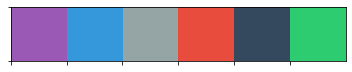

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


def qudratic_r_squared(chro_age, brain_age):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c):
        return a + b*x + c*(x**2)
    
    popt, pcov = curve_fit(qudratic_fun, chro_age, brain_age)
    brain_age_pred = qudratic_fun(chro_age, popt[0], popt[1], popt[2])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)


text_size = 45
# colors = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["amber"], ]
# colors = sns.color_palette("RdBu_r", 7)
# colors = [colors[5], colors[1]]

colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

sns.palplot(colors)
colors = [colors[3], colors[4]]

scatter_para = {'alpha': 0.9, 's': 3, 'linewidth': 0.1}

# column_title = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster all']
# column_title = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
column_title = ['Cluster ' + str(n) for n in range(1, num_cluster)] + ['Unidimension']


def plot_result_gender(plot_data):
    
    plot_data = pd.melt(plot_data, id_vars = ['cluster', 'CV', 'chronological age', 'Sex'], 
                        value_vars = ['brain age', 'age gap', 'age gap corr'])

    cluster_name = plot_data['cluster'].unique()
    variable_name = plot_data['variable'].unique()
    
#     result_table_summary = result_table_summary.sort_index()
    
    # this only draws the scatter dots:
    g = sns.lmplot(x='chronological age', y='value', hue = 'Sex', col = 'cluster', row = 'variable', \
                   row_order = ['brain age','age gap', 'age gap corr'], palette = colors, \
                   data = plot_data, fit_reg=False, sharex = True, sharey = False, \
                   scatter_kws={'alpha':0.6}, x_jitter = .2,\
                   height=10.27, aspect=10.27/10.27, legend = True)
    
    g.axes[0,0].set_xlim(6.5, 23.5)
    
    plt.setp(g._legend.get_title(), fontsize=45)
    for lh in g._legend.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [250] 
    
    ## draws the regression line for each row:
    sub_plot = 0
    for i_cluster in cluster_name:

        i_plot_data = plot_data.loc[(plot_data['cluster']==i_cluster) & (plot_data['variable']=='brain age'),:]
        
        chro_age_m = i_plot_data.loc[(i_plot_data['Sex']=='M','chronological age')].values
        chro_age_f = i_plot_data.loc[(i_plot_data['Sex']=='F','chronological age')].values
        
        brain_age_m = i_plot_data.loc[(i_plot_data['Sex']=='M','value')].values
        brain_age_f = i_plot_data.loc[(i_plot_data['Sex']=='F','value')].values
        
        # chronological age vs age gap:
        label2 = "Male: $R^2$ = %.3f, MAE = %.3f" % \
        (qudratic_r_squared(chro_age_m, brain_age_m),\
         np.mean(np.abs(chro_age_m - brain_age_m)))
        
        label1 = "Female: $R^2$ = %.3f, MAE = %.3f" % \
        (qudratic_r_squared(chro_age_f, brain_age_f),\
         np.mean(np.abs(chro_age_f - brain_age_f)))
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[0], \
                    data = i_plot_data.loc[(i_plot_data['Sex']=='F'),:], scatter=False, \
                    ax=g.axes[0, sub_plot], order = 2)
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[1],\
                    data = i_plot_data.loc[(i_plot_data['Sex']=='M'),:], scatter=False, \
                    ax=g.axes[0, sub_plot], order = 2)

        g.axes[0, sub_plot].text(6.5, 20, label1, fontsize = text_size-5)
        g.axes[0, sub_plot].text(6.5, 21, label2, fontsize = text_size-5)
        g.axes[0, sub_plot].set_ylim(5.5, 22.5)
        
        g.axes[0, sub_plot].set_title(column_title[sub_plot])
        g.axes[0, sub_plot].set_xlabel('')
        
        if sub_plot == 0:
            g.axes[0, sub_plot].set_ylabel('brain age')
        else:
            g.axes[0, sub_plot].set_ylabel('')
            g.axes[0, sub_plot].set(yticklabels=[])
        
        
        sub_plot = sub_plot + 1
    
    text_x = 13.5
    text_y1 = 5
    text_y2 = 6
    
    sub_plot = 0
    for i_cluster in cluster_name:
        
        i_plot_data = plot_data.loc[(plot_data['cluster']==i_cluster) & (plot_data['variable']=='age gap'),:]
        # chronological age vs brain age:
        chro_age_m = i_plot_data.loc[i_plot_data['Sex']=='M', 'chronological age'].values
        chro_age_f = i_plot_data.loc[i_plot_data['Sex']=='F', 'chronological age'].values
        
        age_gap_m = i_plot_data.loc[i_plot_data['Sex']=='M', 'value'].values
        age_gap_f = i_plot_data.loc[i_plot_data['Sex']=='F', 'value'].values
        
        corr_m = np.corrcoef(chro_age_m, age_gap_m)[0,1]
        corr_f = np.corrcoef(chro_age_f, age_gap_f)[0,1]
        # chronological age vs brain age:
        label2 = "Male: r = %.3f" % corr_m
        label1 = "Female: r = %.3f" % corr_f
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[0], \
                    data = i_plot_data.loc[i_plot_data['Sex']=='F',:], scatter=False, 
                    ax=g.axes[1, sub_plot], order = 1)
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[1],\
                    data = i_plot_data.loc[i_plot_data['Sex']=='M',:], scatter=False, 
                    ax=g.axes[1, sub_plot], order = 1)

        #text_y = plot_data['brain age'].max()+.2
        g.axes[1, sub_plot].text(text_x, text_y1, label1, fontsize = text_size)
        g.axes[1, sub_plot].text(text_x, text_y2, label2, fontsize = text_size)
        
        g.axes[1, sub_plot].set_title('')
        g.axes[1, sub_plot].set_xlabel('')
        g.axes[1,sub_plot].set_ylim(-6.5, 7)
        
        if sub_plot == 0:
            g.axes[1, sub_plot].set_ylabel('BAG')
        else:
            g.axes[1, sub_plot].set_ylabel('')
            g.axes[1, sub_plot].set(yticklabels=[])
        sub_plot = sub_plot + 1
        
    sub_plot = 0
    for i_cluster in cluster_name:
        
        i_plot_data = plot_data.loc[(plot_data['cluster']==i_cluster) & (plot_data['variable']=='age gap corr'),:]
        # chronological age vs brain age:
        chro_age_m = i_plot_data.loc[i_plot_data['Sex']=='M', 'chronological age'].values
        chro_age_f = i_plot_data.loc[i_plot_data['Sex']=='F', 'chronological age'].values
        
        age_gap_m = i_plot_data.loc[i_plot_data['Sex']=='M', 'value'].values
        age_gap_f = i_plot_data.loc[i_plot_data['Sex']=='F', 'value'].values
        
        corr_m = np.corrcoef(chro_age_m, age_gap_m)[0,1]
        corr_f = np.corrcoef(chro_age_f, age_gap_f)[0,1]
        # chronological age vs brain age:
        label2 = "Male: r = %.3f" % corr_m
        label1 = "Female: r = %.3f" % corr_f
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[0], \
                    data = i_plot_data.loc[i_plot_data['Sex']=='F',:], scatter=False, 
                    ax=g.axes[2, sub_plot], order = 1)
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[1],\
                    data = i_plot_data.loc[i_plot_data['Sex']=='M',:], scatter=False, 
                    ax=g.axes[2, sub_plot], order = 1)

        #text_y = plot_data['brain age'].max()+.2
        g.axes[2, sub_plot].text(text_x, text_y1, label1, fontsize = text_size)
        g.axes[2, sub_plot].text(text_x, text_y2, label2, fontsize = text_size)
        
        g.axes[2, sub_plot].set_title('')
        g.axes[2, sub_plot].set_ylim(-6.5, 7)
        
        if sub_plot == 0:
            g.axes[2, sub_plot].set_ylabel('corrected BAG')
        else:
            g.axes[2, sub_plot].set_ylabel('')
            g.axes[2, sub_plot].set(yticklabels=[])
        sub_plot = sub_plot + 1

In [5]:
scatter_data['cluster'].unique()

[cluster 1, cluster 2, cluster 3, cluster 4, cluster all]
Categories (5, object): [cluster 1 < cluster 2 < cluster 3 < cluster 4 < cluster all]

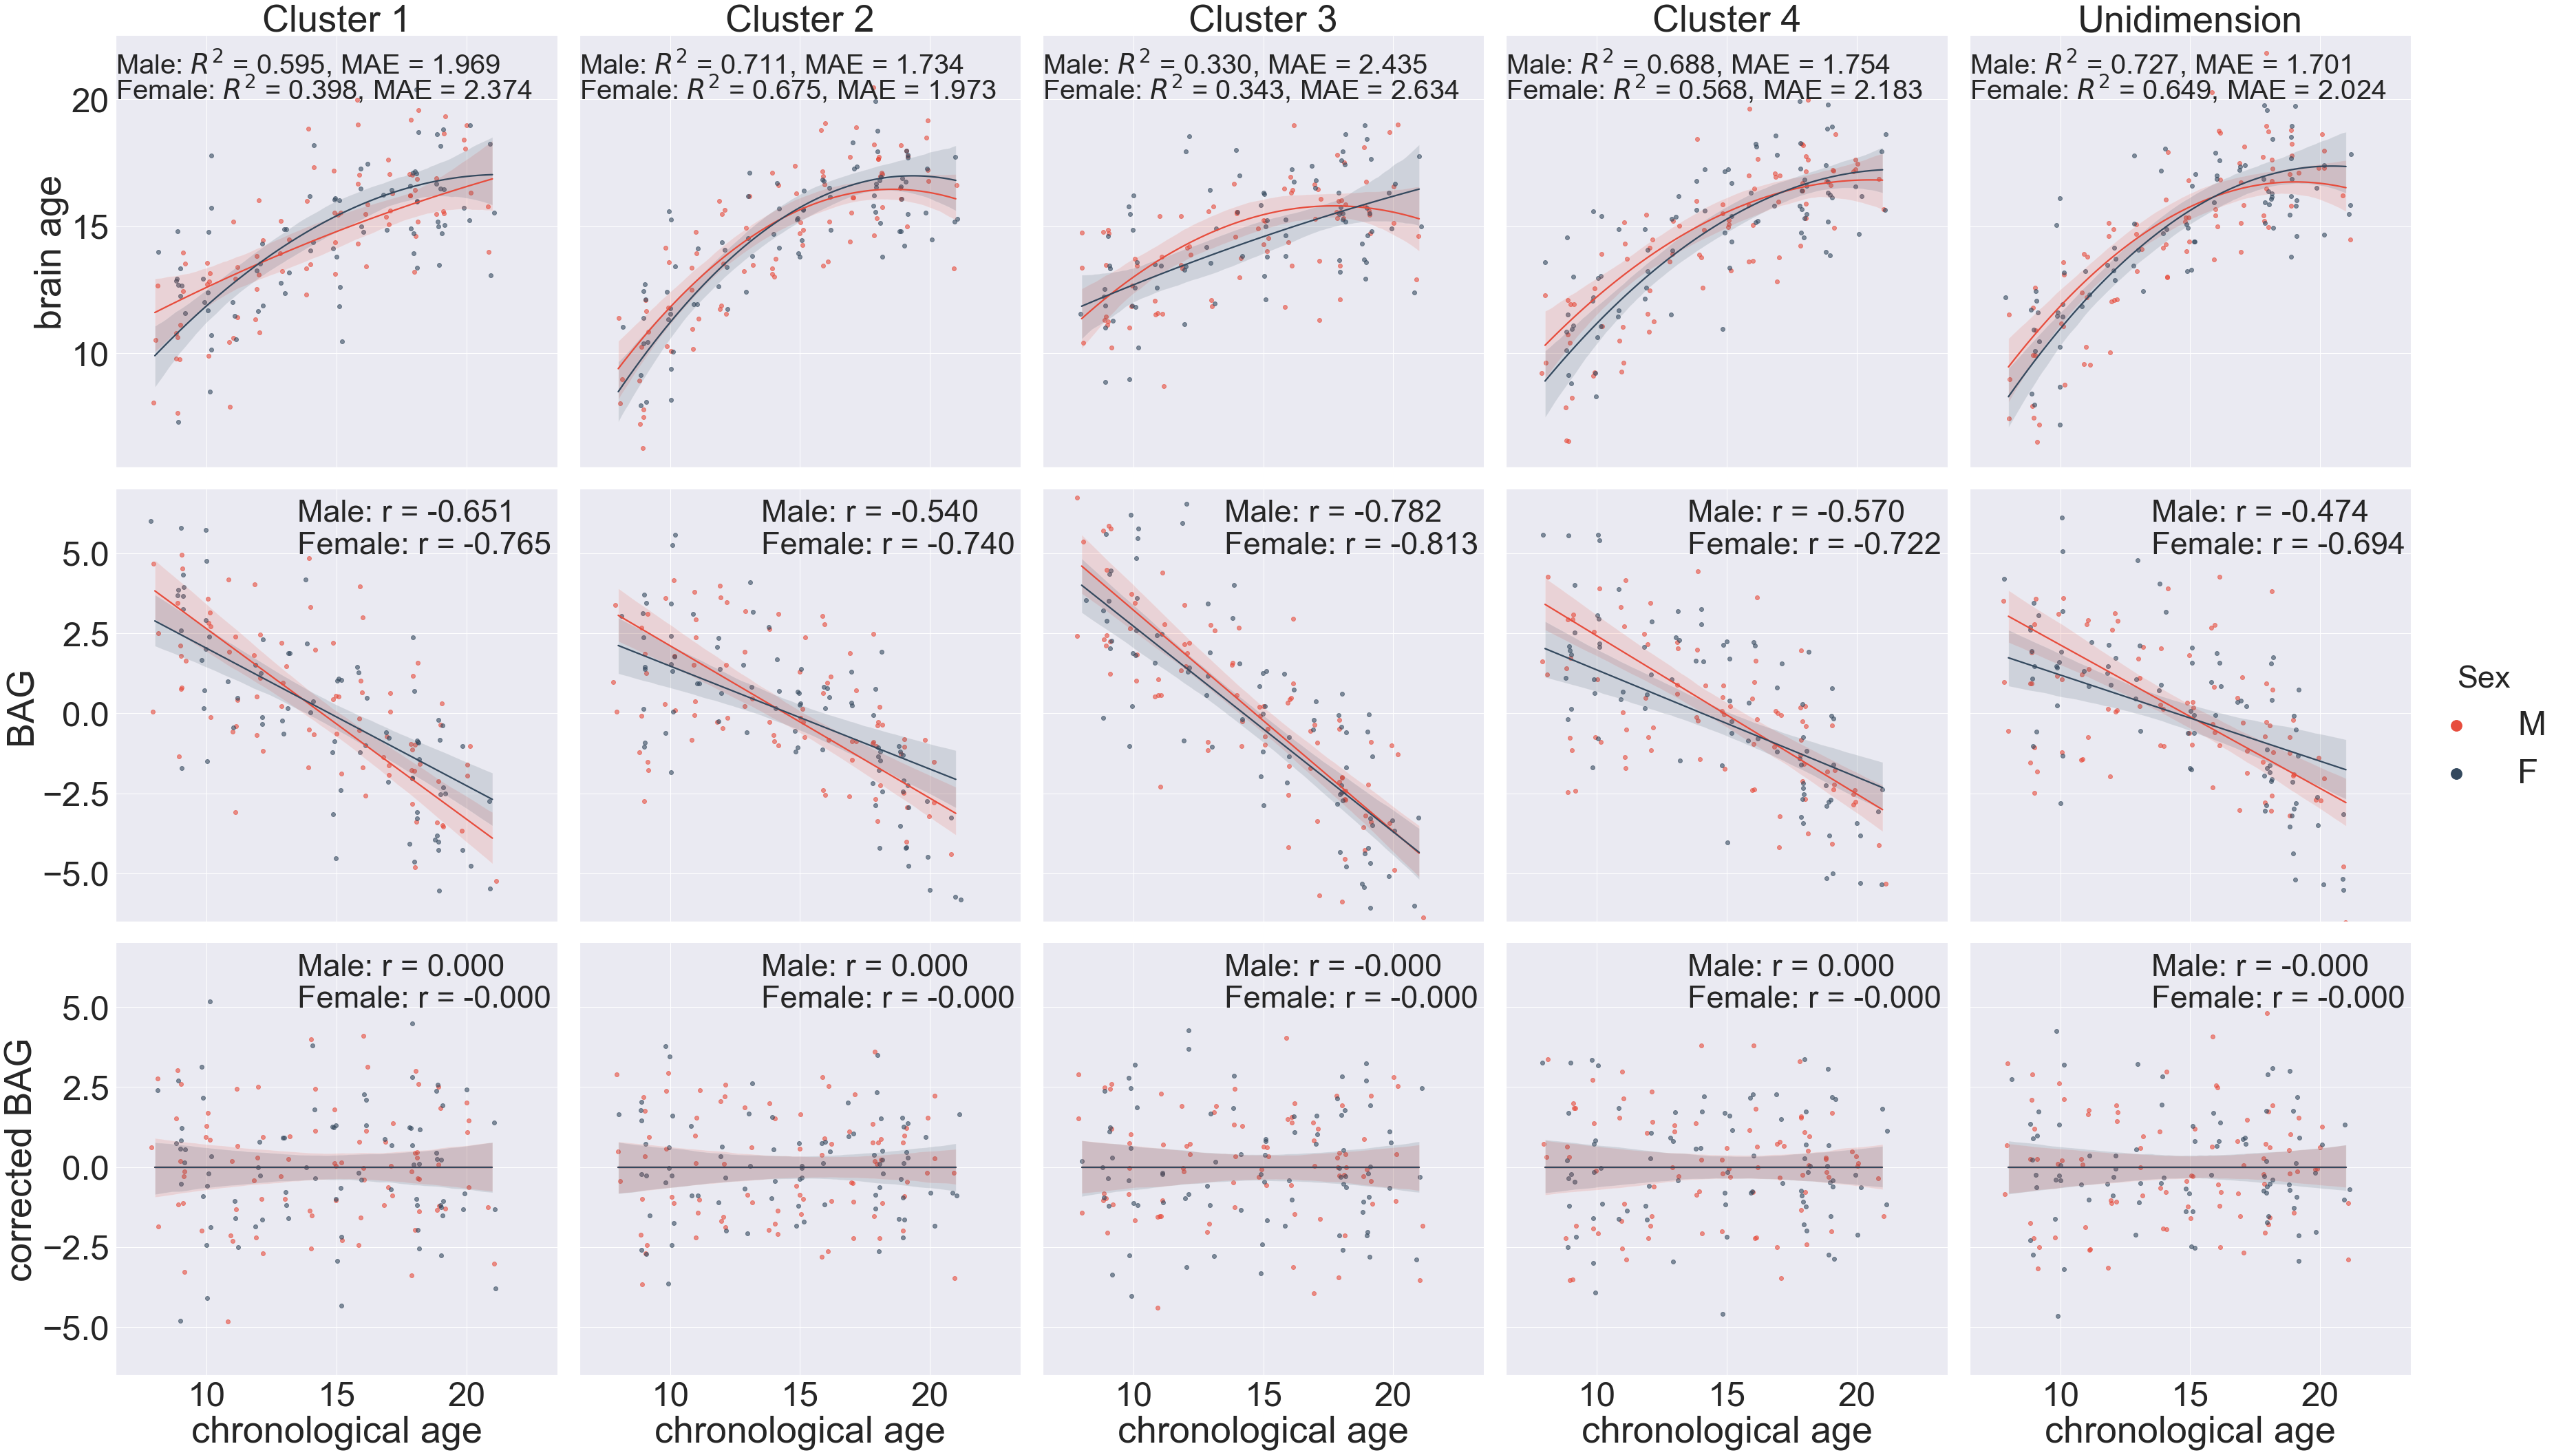

In [6]:
sns.set(rc={'figure.figsize':(9, 9)}, font_scale = 4.5)
plot_result_gender(scatter_data)

plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.savefig(output_dir+'/figure4_scatter_merge_gender_intersex_' + method + '_' + model + '.png', dpi=300)